In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

%cd /Midgard/home/amirme/an_explanation_model
from source.project_manager import (
    load_experiment_metadata,
    delete_experiment_data,
    check_file_exists,
)
from source.data_manager import minmax_normalize,symmetric_minmax_normalize,sum_channels
from source.labels import IMAGENET_LABELS

/Midgard/home/amirme/an_explanation_model


2023-09-01 17:43:19.328416: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-01 17:43:20.698442: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/Midgard/home/amirme/miniconda3/envs/xmodel/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
project_metadata = load_experiment_metadata(glob_path="noise_interpolation/*")
print(project_metadata.columns)
project_metadata = project_metadata.set_index(["stream_name","stream_statistic"]).sort_index()
print(project_metadata.shape)

Index(['method', 'alpha_mask_type', 'alpha_mask_value', 'projection_type',
       'projection_index', 'projection_distribution', 'baseline_mask_type',
       'baseline_mask_value', 'write_demo', 'architecture', 'max_batches',
       'min_change', 'seed', 'batch_size', 'num_classes', 'input_shape',
       'image_index', 'monitored_statistic', 'monitored_stream', 'dataset',
       'label', 'image_path', 'time_to_compute', 'batch_index',
       'monitored_statistic_change', 'data_path', 'stream_name',
       'stream_statistic', 'csv_file_path'],
      dtype='object')
(560, 27)


In [3]:
vc = project_metadata.index.value_counts()
print(vc)
print(len(vc))

stream_name              stream_statistic
alpha_mask               none                40
baseline_mask            none                40
convex_combination_mask  none                40
image                    none                40
log_probs                meanx               40
                         meanx2              40
                         none                40
projection               none                40
results_at_projection    meanx               40
                         meanx2              40
                         none                40
vanilla_grad_mask        meanx               40
                         meanx2              40
                         none                40
Name: count, dtype: int64
14


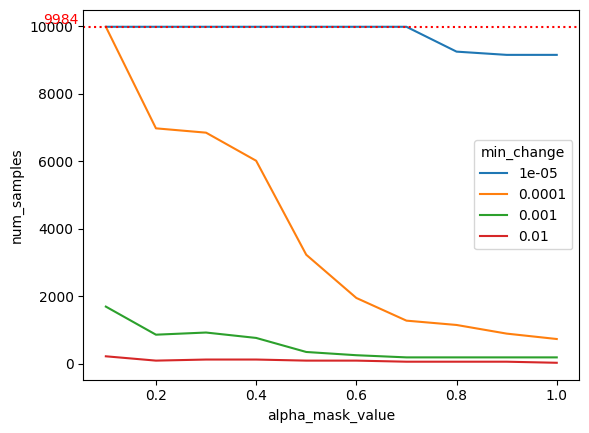

In [4]:
temp_df = project_metadata.loc[("log_probs","none"),:]
alpha_min_change_num_samples_tbl = temp_df.pivot(index="alpha_mask_value",columns="min_change",values="batch_index")
alpha_min_change_batch_size_tbl = temp_df.pivot(index="alpha_mask_value",columns="min_change",values="batch_size")
alpha_min_change_num_samples_tbl = alpha_min_change_num_samples_tbl*alpha_min_change_batch_size_tbl
alpha_min_change_num_samples_tbl.plot()
plt.ylabel("num_samples")

# max_batches
temp_row = project_metadata.iloc[0,:]
max_samples = temp_row["max_batches"] * temp_row["batch_size"]
plt.axhline(y=max_samples, color="red",linestyle=":")
plt.text(0.01,max_samples, f"{max_samples:.0f}", color="red", ha="center", va="bottom");

In [33]:
project_metadata.loc[("log_probs","none")].groupby("min_change")["time_to_compute"].agg(['sum','count'])

sum  count
min_change                   
0.00001     394.365017     10
0.00010     241.250405     10
0.00100     149.559727     10
0.01000     139.923863     10

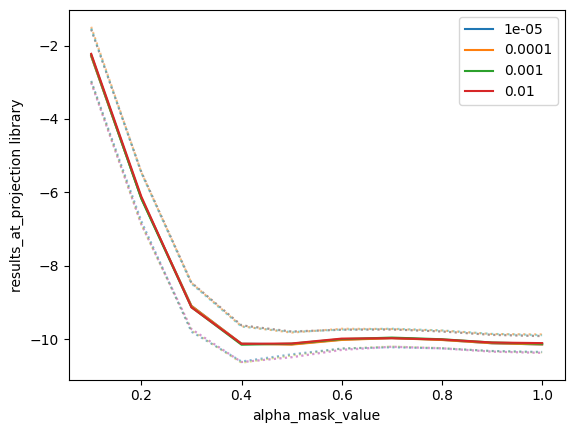

In [6]:
selected_rows = project_metadata.loc["results_at_projection",:]
selected_rows = selected_rows.set_index("alpha_mask_value",append=True).sort_index()
values = selected_rows.loc[:,"data_path"].apply(lambda path: np.load(path))
selected_rows = selected_rows.loc["meanx",:]

meanx = values.loc["meanx"]
std = np.sqrt(values.loc["meanx2"] - values.loc["meanx"]**2)
meanx.name = "meanx"
std.name = "stdx"
selected_rows = pd.concat([selected_rows,meanx,std],axis=1)
groupped = selected_rows.groupby("min_change")
groupped["meanx"].plot(legend=True)
groupped.apply(lambda x: plt.plot(
    x.index, 
    x["meanx"] - x["stdx"], 
    x.index,
    x["meanx"] + x["stdx"], 
    alpha=0.5,
    linestyle=":"))
temp_row = project_metadata.iloc[0,:]["label"]
plt.ylabel(f"results_at_projection {IMAGENET_LABELS[temp_row]}");

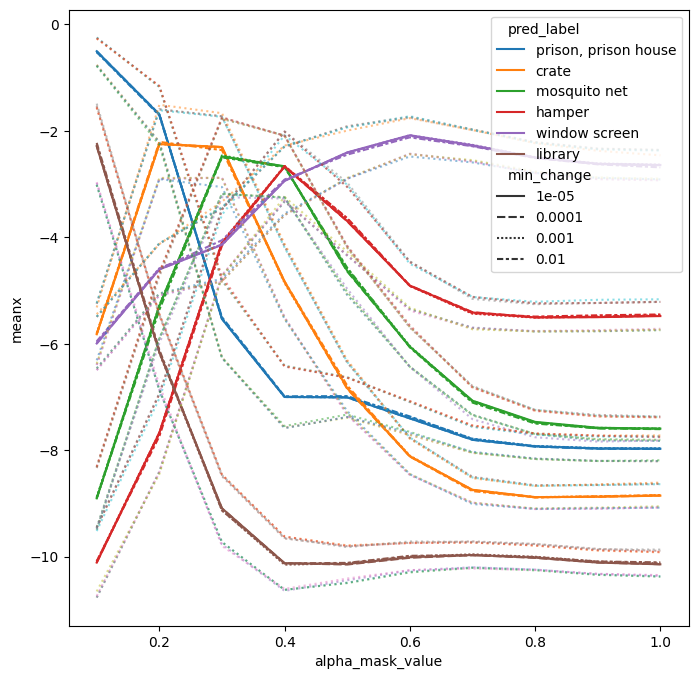

In [35]:
temp_metadata = project_metadata.set_index(["alpha_mask_value","min_change"],append=True).sort_index()
temp_metadata = temp_metadata.loc[("log_probs"),:]
values = temp_metadata.loc[:,"data_path"].apply(lambda path: np.load(path))
temp_row = project_metadata.iloc[0,:]["label"]

meanx = values.loc["meanx"]
meanx2 = values.loc["meanx2"]

meanx.name = "meanx"
stdx = (meanx2 - meanx**2).apply(lambda x: np.sqrt(x))
stdx.name = "stdx"
pred_ids = list(meanx.apply(np.argmax).unique())
pred_ids.append(temp_row)

temp_metadata = []
for pred_id in pred_ids:
    topk_meanx = meanx.apply(lambda x:x[pred_id])
    topk_stdx = stdx.apply(lambda x:x[pred_id])
    new_indexer = pd.Series(data = pred_id, index=meanx.index,name="pred_idx")
    temp_cols = pd.concat([topk_meanx,topk_stdx,new_indexer],axis=1)
    temp_metadata.append(temp_cols)

temp_metadata = pd.concat(temp_metadata)
temp_metadata["pred_label"] = temp_metadata["pred_idx"].apply(lambda x:IMAGENET_LABELS[x][:30])
temp_metadata = temp_metadata.set_index("pred_idx",append=True)

fig,ax = plt.subplots(1,1,figsize=(8,8))
sns.lineplot(ax=ax,x="alpha_mask_value", y="meanx",
             hue="pred_label", style="min_change",
             data=temp_metadata,palette="tab10")

groupped = temp_metadata.groupby(["pred_idx","min_change"])
groupped.apply(lambda x: ax.plot(
    x.index.get_level_values('alpha_mask_value'), 
    x["meanx"] - x["stdx"], 
    x.index.get_level_values('alpha_mask_value'),
    x["meanx"] + x["stdx"], 
    alpha=0.5,
    linestyle=":"));

In [23]:
get_title_alpha = lambda i,mask,masks: f"alpha={masks.index[i]:.2f} min={mask.min():.2f} max={mask.max():.2f}"
get_title_min_change = lambda i,mask,masks: f"min_change={masks.index.get_level_values('min_change')[i]} min={mask.min():.2f} max={mask.max():.2f}"

def selector(selection,processes=[]):
    temp_metadata = project_metadata.set_index(["min_change","alpha_mask_value"],append=True).sort_index()
    temp_metadata = temp_metadata.loc[selection,:]
    masks = temp_metadata["data_path"].apply(lambda x:np.load(x))
    
    for process in processes:
        masks = masks.apply(process)
        
    return masks
    
def plot_masks(selection,processes=[],imshow_args={"cmap":"viridis"},get_title=get_title_alpha,nrows=2):
    masks = selector(selection,processes)
        
    nrows = nrows
    ncols = len(masks)//nrows
    factor = 4
    fig,axes = plt.subplots(nrows,ncols,figsize=(ncols*factor,nrows*factor))
    for i,ax in enumerate(axes.flatten()):
        mask = masks.iloc[i]
        ax.imshow(mask,**imshow_args)
        ax.set_title(get_title(i,mask,masks))
    return masks

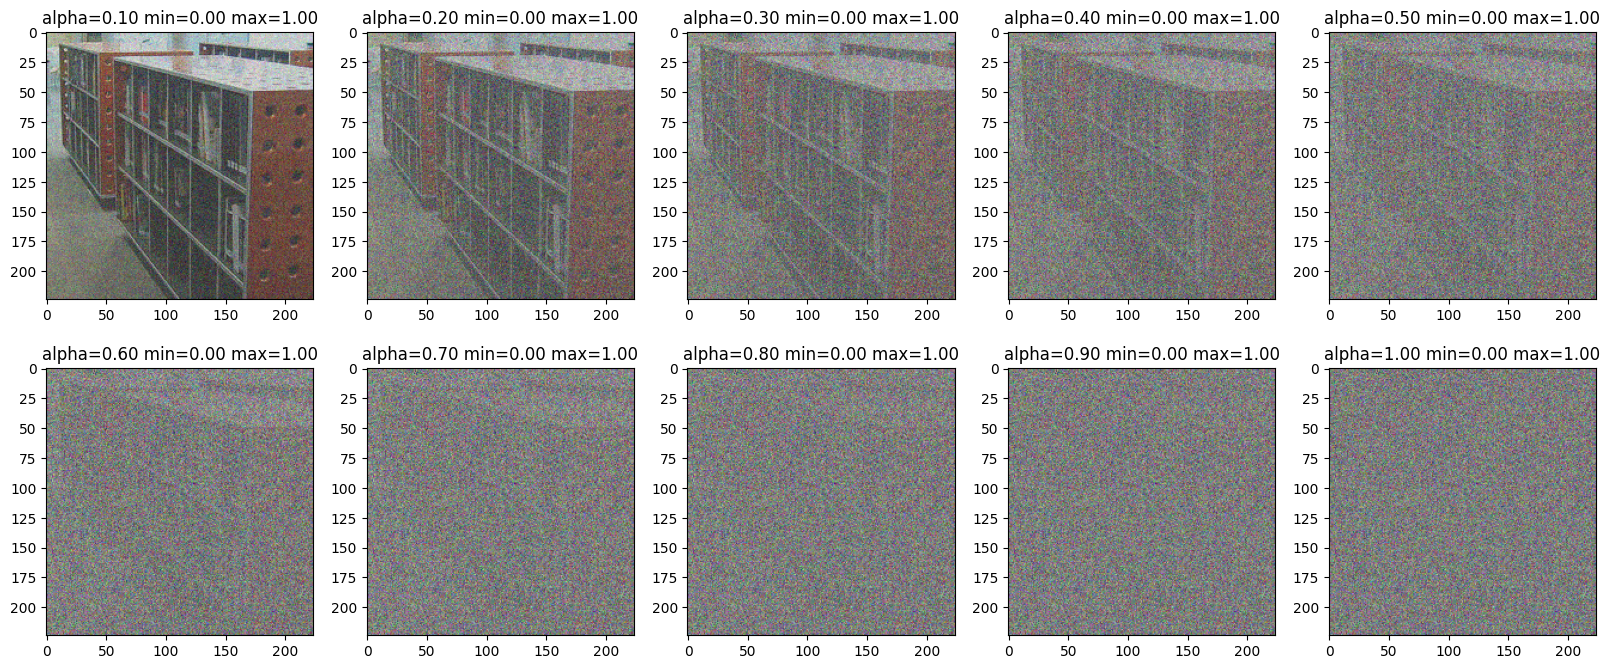

In [15]:
plot_masks(("convex_combination_mask","none",1e-5));

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

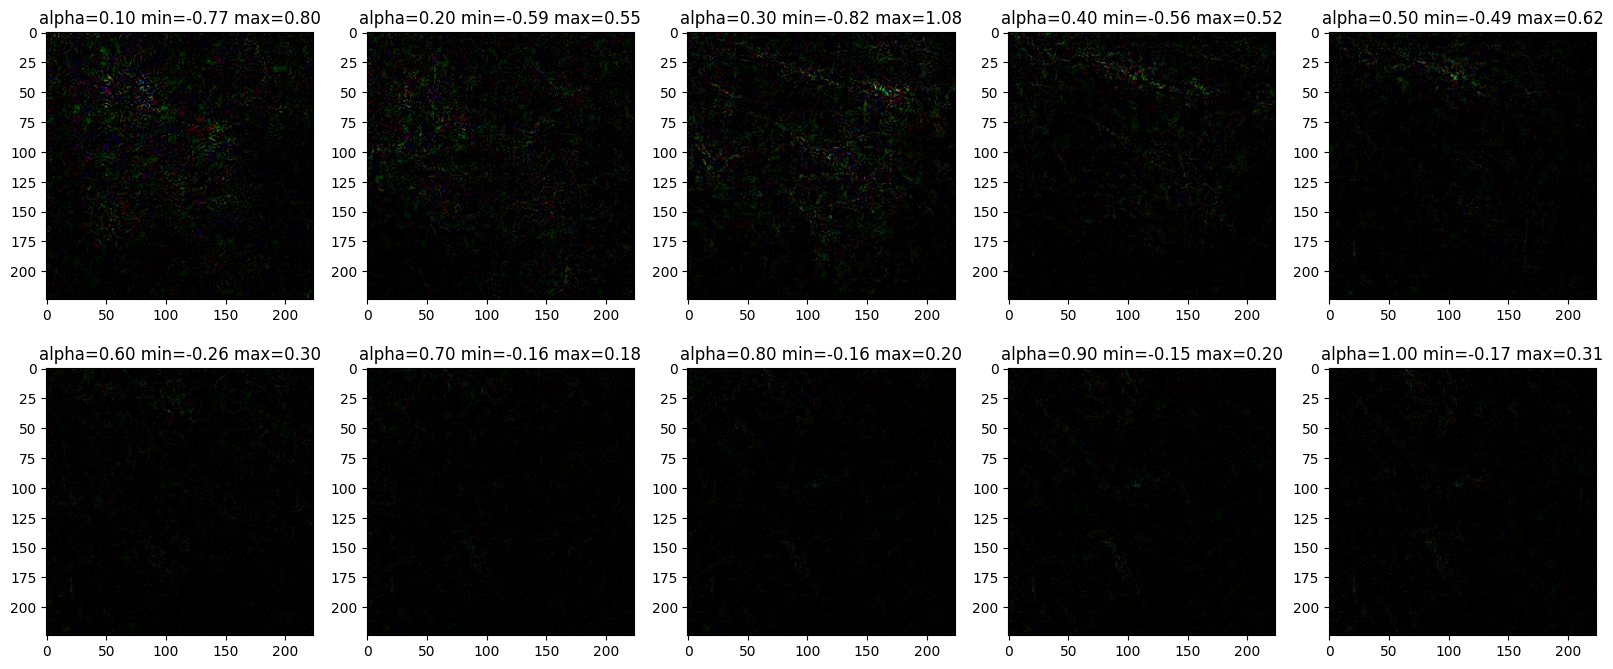

In [16]:
plot_masks(("vanilla_grad_mask","none",1e-5));

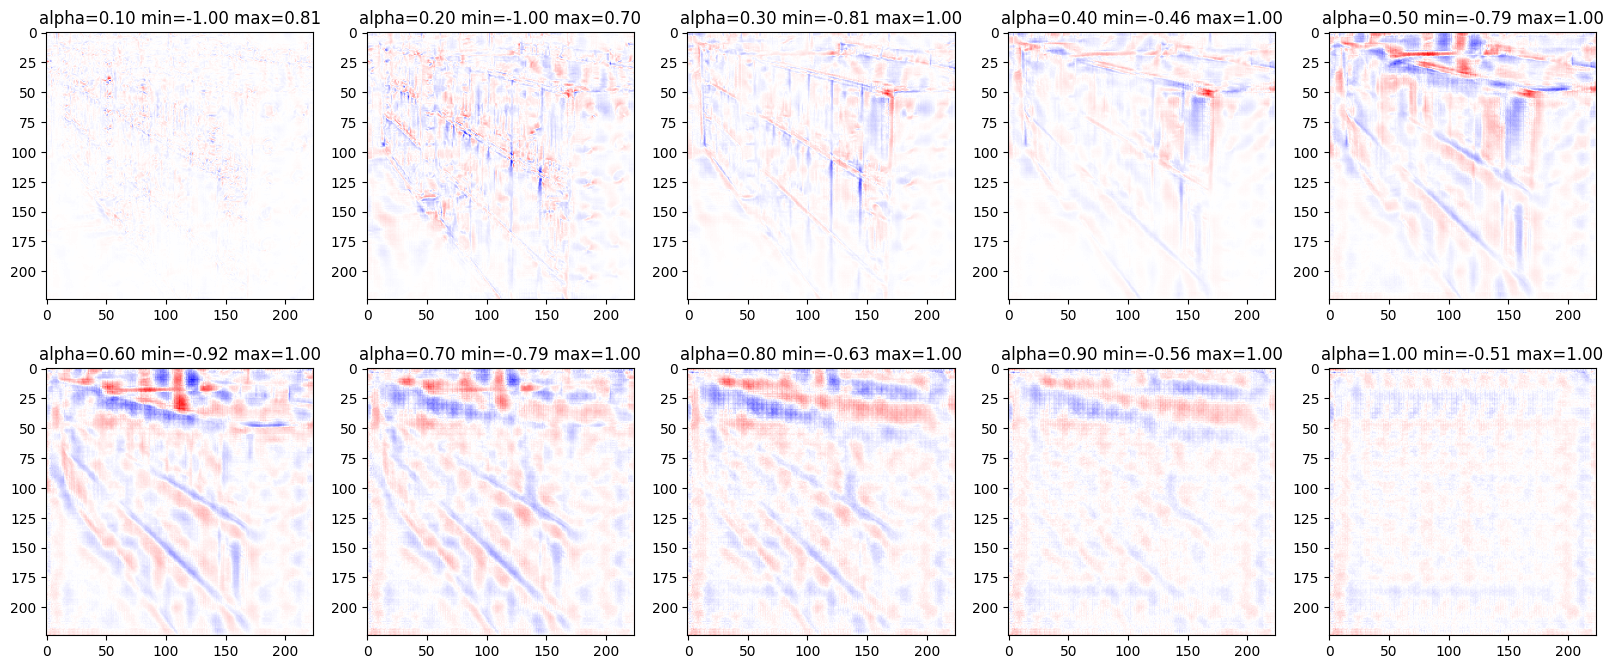

In [17]:
imshow_args = {"cmap":'bwr',"vmin":-1,"vmax":1}
plot_masks(("vanilla_grad_mask","meanx",1e-5),processes=[sum_channels,symmetric_minmax_normalize],imshow_args=imshow_args);

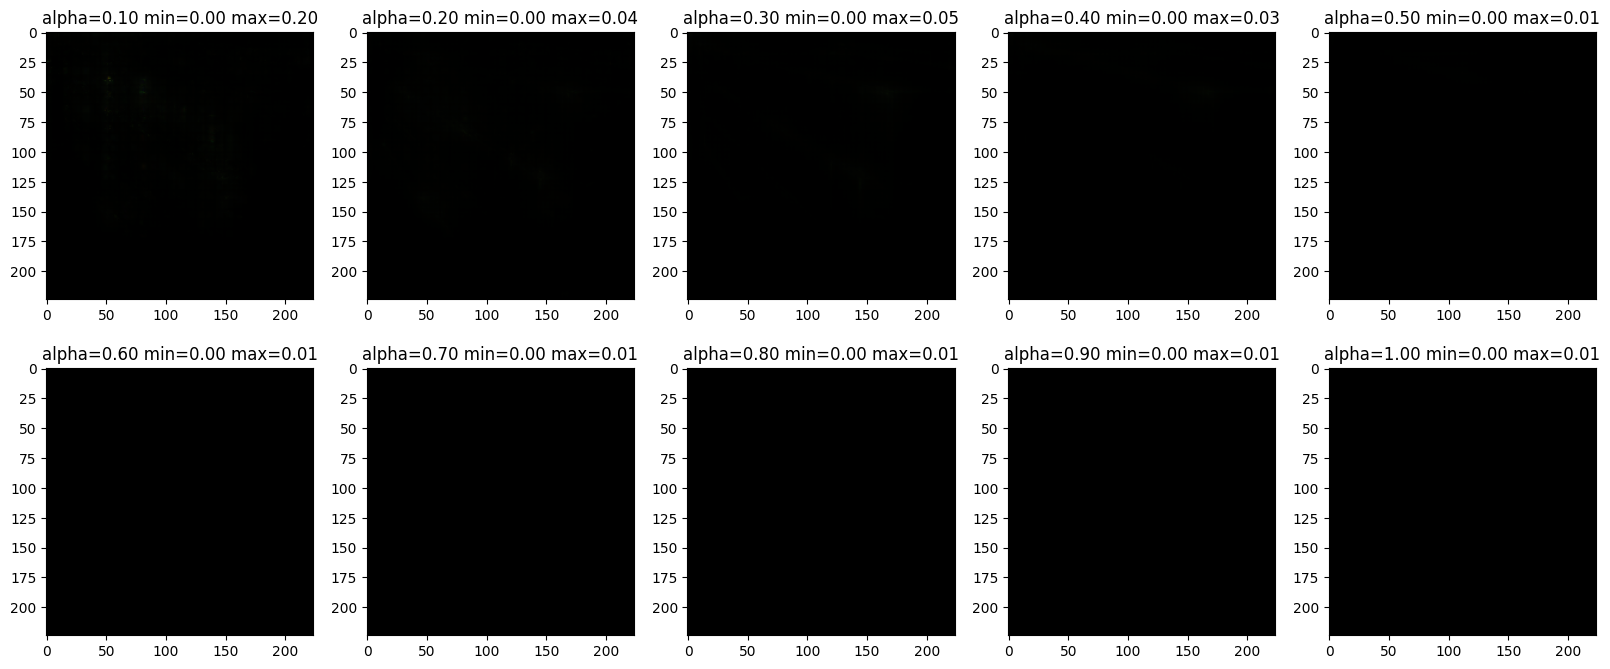

In [18]:
plot_masks(("vanilla_grad_mask","meanx2",1e-5));

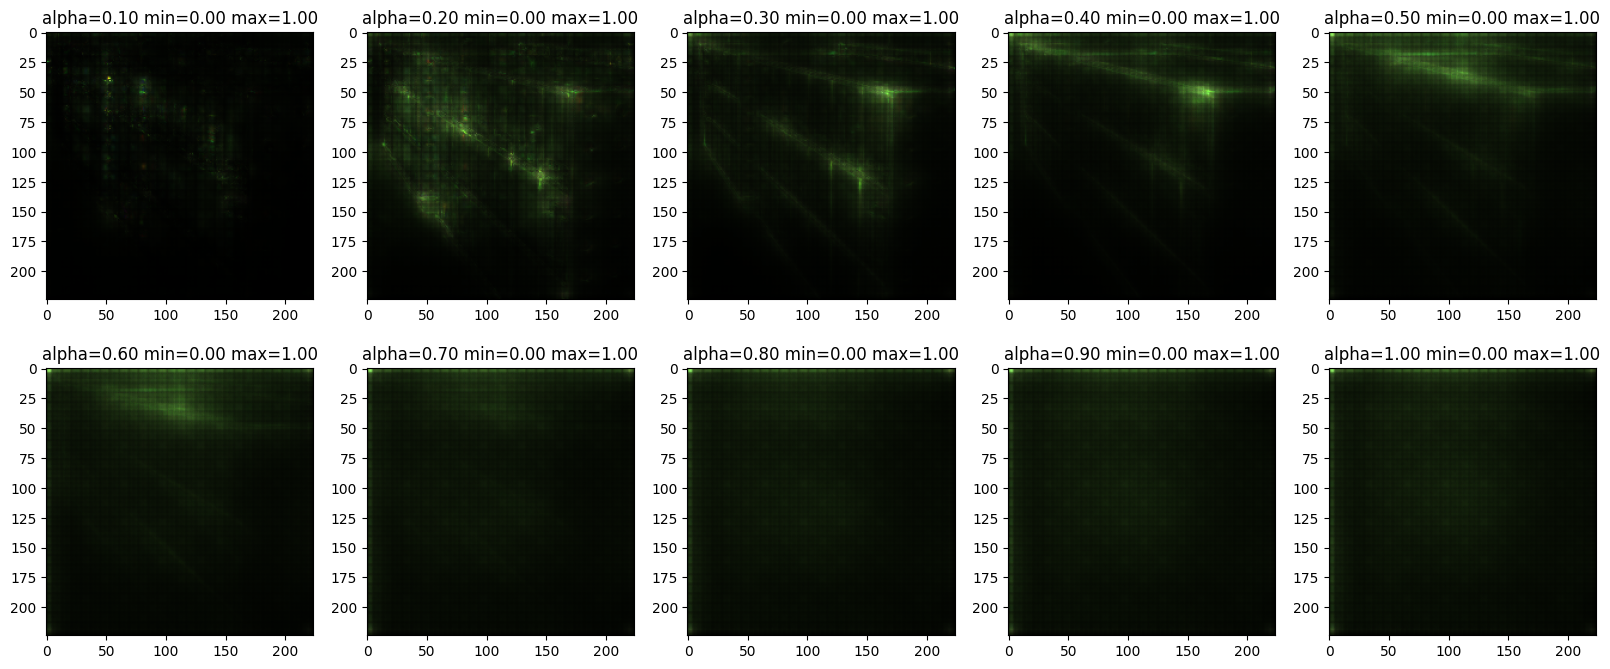

In [19]:
plot_masks(("vanilla_grad_mask","meanx2",1e-5),processes=[minmax_normalize]);

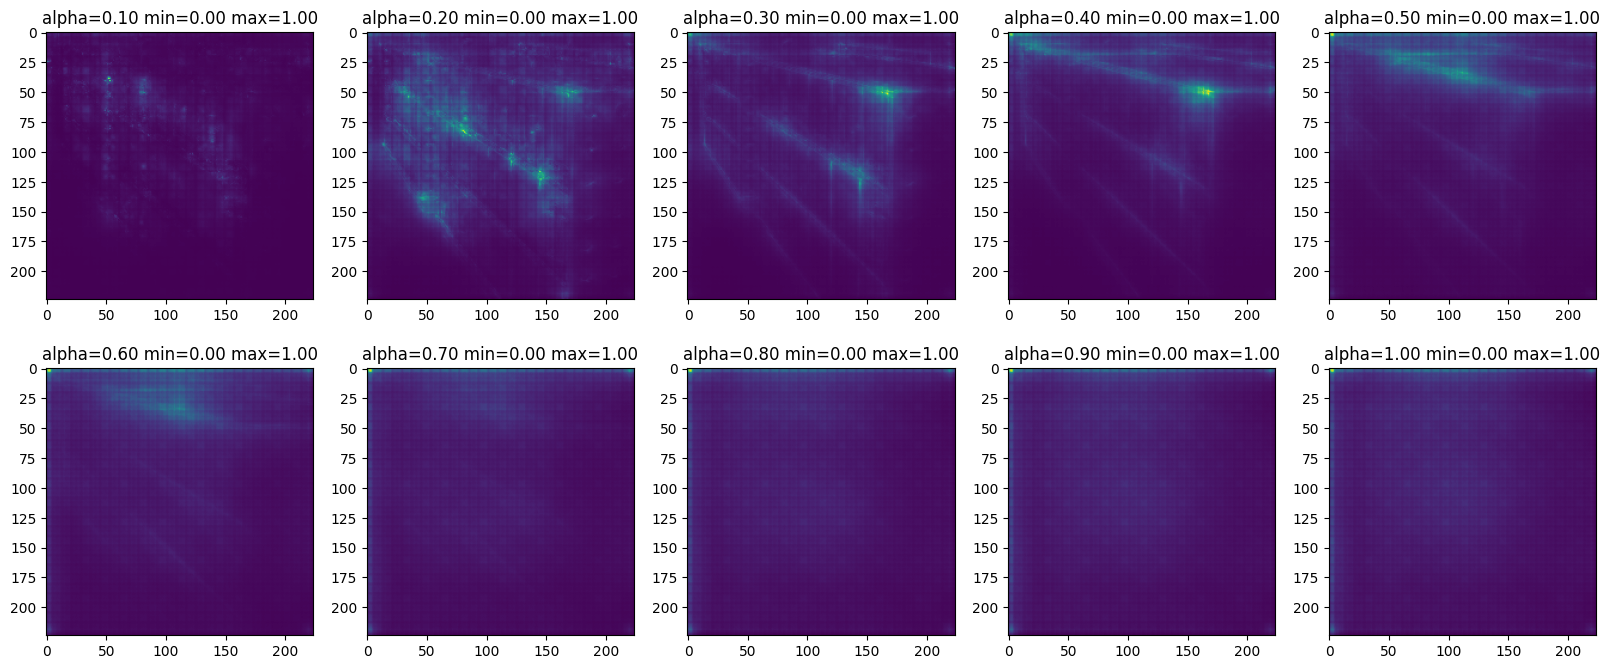

In [20]:
plot_masks(("vanilla_grad_mask","meanx2",1e-5),processes=[sum_channels,minmax_normalize]);

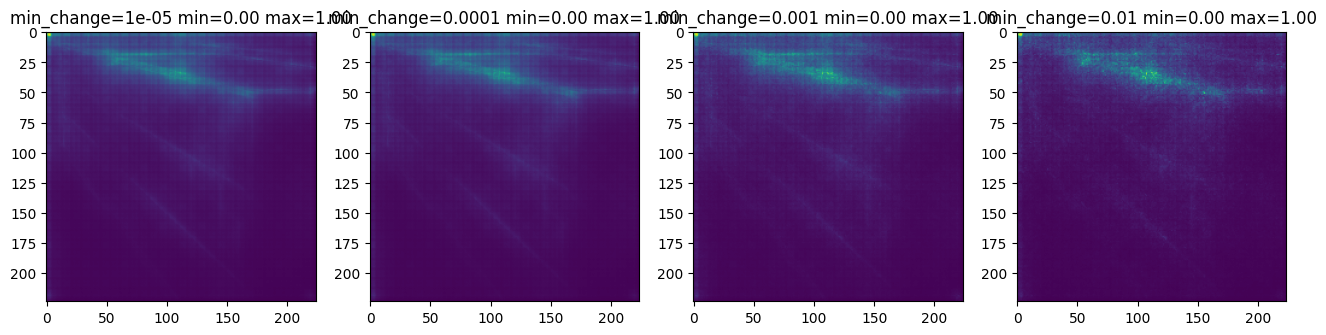

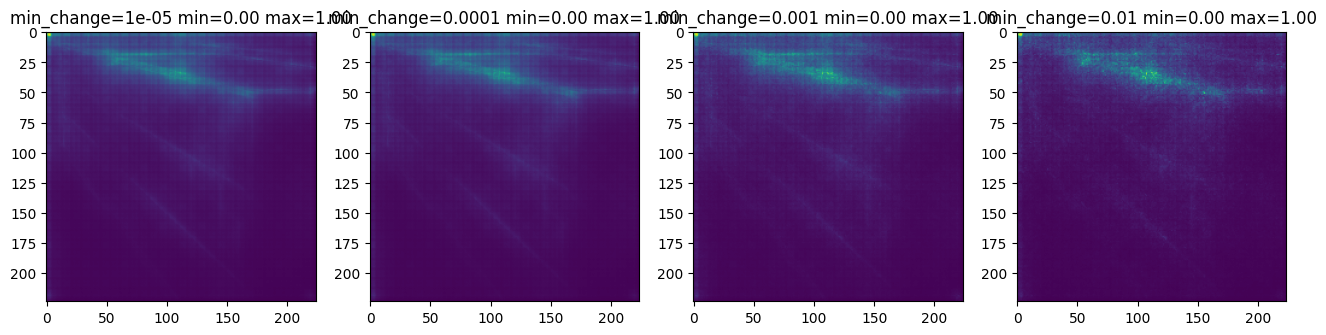

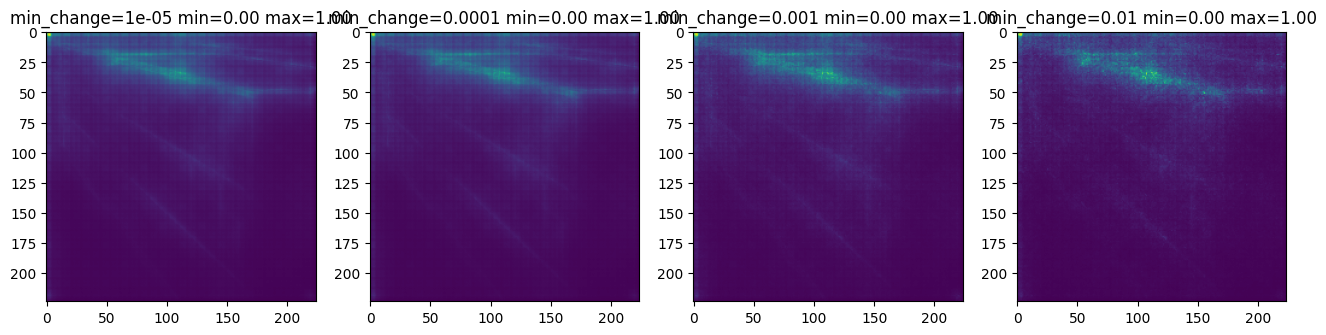

In [46]:
alphas = [0.1,0.3,0.5]
for alpha in alphas:
    plot_masks(("vanilla_grad_mask","meanx2",slice(None),min_change),
               processes=[sum_channels,minmax_normalize],
               get_title=get_title_min_change,nrows=1);

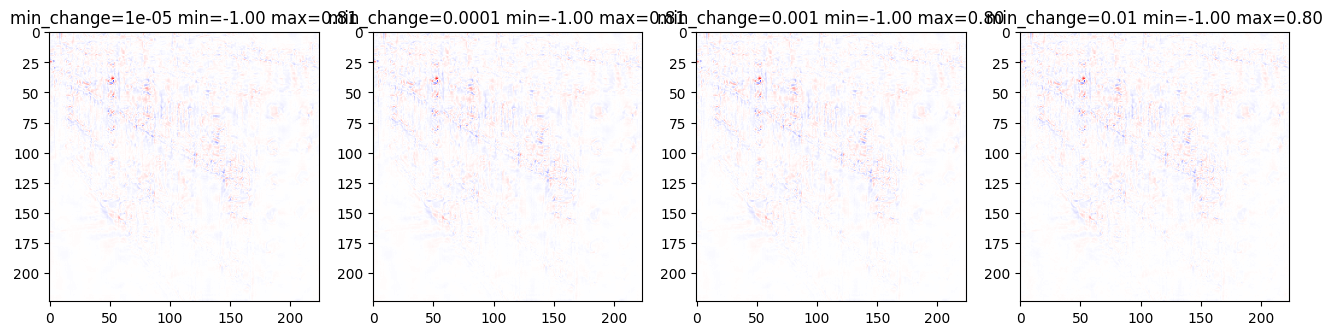

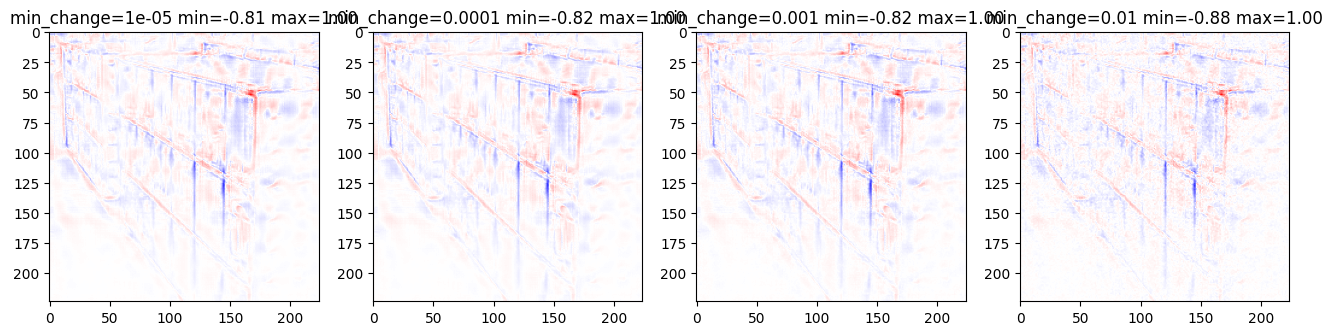

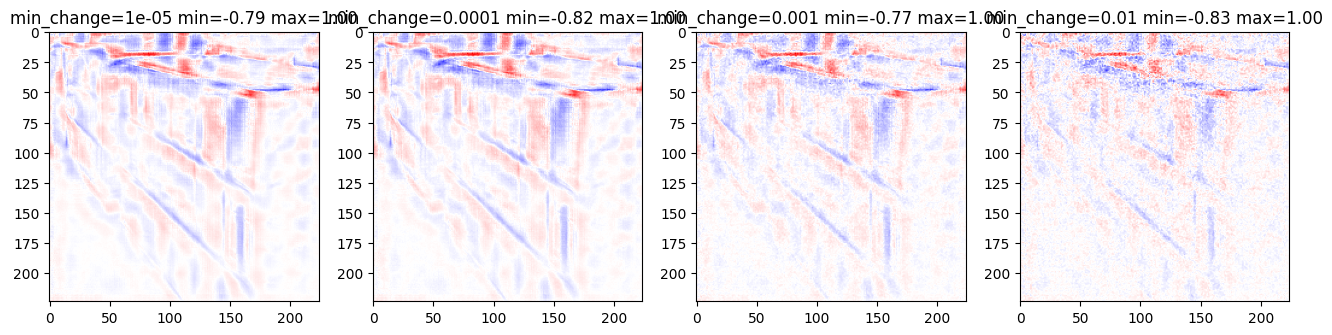

In [45]:
for alpha in alphas:
    plot_masks(("vanilla_grad_mask","meanx",slice(None),alpha),
               processes=[sum_channels,symmetric_minmax_normalize],
               get_title=get_title_min_change,nrows=1,
              imshow_args=imshow_args);

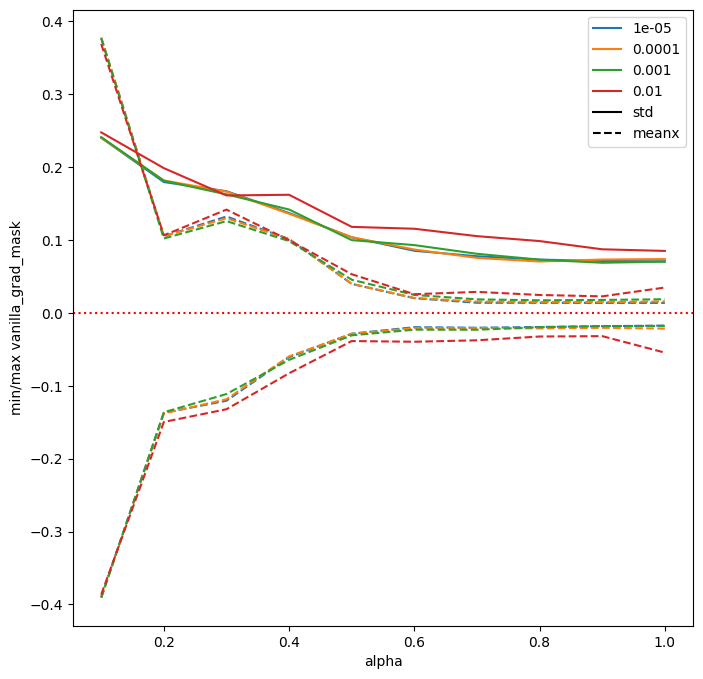

In [48]:
# summarize vanilla grad masks and show in one plot to compare the scales of meanx and meanx2
min_masks = pd.concat({"meanx":selector(("vanilla_grad_mask","meanx"),processes=[np.min])})
max_masks = pd.concat({"meanx2":selector(("vanilla_grad_mask","meanx2"),processes=[np.max]),
             "meanx":selector(("vanilla_grad_mask","meanx"),processes=[np.max])})
masks = pd.concat({"min":min_masks,"max":max_masks})

masks_stacked = masks.reset_index().pivot(index="alpha_mask_value",columns=["min_change","level_1","level_0"],values="data_path")

fig,ax = plt.subplots(1,1,figsize=(8,8))
min_changes = masks_stacked.columns.get_level_values(0).unique()
colors =  plt.cm.tab10(range(len(min_changes)))

for j,(i,group) in enumerate(masks_stacked.groupby(["min_change"],axis=1)):
    group = group[i]
    ax.plot(np.sqrt(group["meanx2"]-group["meanx"]**2),c=colors[j])
    ax.plot(group["meanx"],c=colors[j],linestyle='--')
    
    ax.plot([],[],c=colors[j],label=i[0])
                         
ax.plot([],[],c='k',label="std")
ax.plot([],[],c='k',linestyle="--",label='meanx')
ax.axhline(y=0,linestyle=":",c='r')
plt.legend()
plt.ylabel("min/max vanilla_grad_mask")
plt.xlabel("alpha");

## Final thoughts on experiment_0.ipynb
in experiment zero we wanted to settle on a good choice for min change. 
seems that setting min change to 0.001 is enough as it is fast and yet the results are not grainy.

## Path: experiment_1.ipynb
in the next experiment we will try to find consistent behaviors of the model with different alpha values.
for example here we have two interesting behaviors:
1. as alpha increases the gradients become less grainy. i.e. we go from a low spatial frequency to a high spatial frequency. is this a consistent behavior?
2. window class is the top class with very low entropy. is this a consistent behavior?
3. compare noise baseline with zero baseline. how are they different?

In [61]:
!ls /local_storage/users/amirme/raw_data/noise_interpolation

In [62]:
!ls /local_storage/users/amirme/metadata/noise_interpolation